# Generar clusters

In [63]:
import os
import pandas as pd
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [64]:
from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)
simplefilter(action="ignore", category=FutureWarning)

In [65]:
'''leer los archivos en un carpeta dada SI son archivos CSV'''
def leer_dir(path, cond1 = 'resumen_anual'):
    with os.scandir(path) as ficheros:
        ficheros = [fichero.name for fichero in ficheros if fichero.is_file() 
                                                            and fichero.name.endswith('.csv') 
                                                            and fichero.name.count(cond1)>0]                                                        
    ficheros.sort()
    return ficheros

def resumen(df,col):
    res=pd.DataFrame()
    aux=df[df['anio']>=2011].reset_index(drop=True).mean()
    res[col]=aux.drop('anio')
    return res.reset_index(drop=True)



In [78]:
'''Preparación de datos para clusterización - Datos satelitales'''
archivo=leer_dir('../datos/1.0.variables/')
df_variables=pd.DataFrame()
for i in archivo:
    df= pd.read_csv('../datos/1.0.variables/'+i)
    col=i.replace('resumen_anual_','').replace('.csv','')
    df_variables=pd.concat([df_variables,resumen(df,col)], axis=1)

p2 = '../datos/1.0.Estaciones/estaciones_senamhi_generado.csv'
cols = ['id', 'lon', 'lat', 'altitud', 'estacion']
estaciones = pd.read_csv(p2, usecols=cols)[cols]
est=pd.concat([estaciones,df_variables], axis=1)


In [119]:
df_cluster= est.drop(['tmed','spei1','spei3','spei6','spi1','spi12','spi3','spi6'],axis=1)

'''Normalización de las variables'''
df_norm=df_cluster.drop(['id','estacion'],axis=1)
df_norm=(df_norm-df_norm.min())/(df_norm.max()-df_norm.min())
df_norm.describe()

,lon,lat,altitud,hmed,pp_bc,spei12,tmax_bc,tmin_bc
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.591009,0.520110,0.311328,0.493275,0.395179,0.370415,0.659214,0.487855
std,0.295029,0.320345,0.257982,0.247914,0.269972,0.278787,0.225301,0.262020
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375342,0.228923,0.107078,0.343765,0.175125,0.119724,0.585635,0.276563
50%,0.626736,0.521649,0.276770,0.478937,0.401226,0.319592,0.712602,0.485967
75%,0.798180,0.735822,0.411978,0.676466,0.509679,0.570488,0.801882,0.653191
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [120]:
'''Método de Elbow: wss = inter-cluster sum of squares '''
wss = []
for i in range (1,11):
    kmeans=KMeans(n_clusters=i,max_iter=300)
    kmeans.fit(df_norm)
    wss.append(kmeans.inertia_)

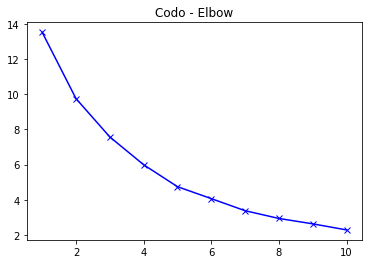

In [121]:
plt.plot(range(1,11),wss,'bx-')
plt.title("Codo - Elbow")
plt.show()

In [122]:
'''Método de Silhoute'''
for i in range(2,8):
    labels=KMeans(n_clusters=i,init="k-means++",random_state=200).fit(df_norm).labels_
    print ("Puntaje Silhouette para "+str(i)+" clusters es  "
           +str(metrics.silhouette_score(df_norm,labels,metric="euclidean",sample_size=1000,random_state=200)))

Puntaje Silhouette para 2 clusters es  0.20816921004046277
Puntaje Silhouette para 3 clusters es  0.20852907939956203
Puntaje Silhouette para 4 clusters es  0.2547738908961459
Puntaje Silhouette para 5 clusters es  0.24641887975927745
Puntaje Silhouette para 6 clusters es  0.2410148594908131
Puntaje Silhouette para 7 clusters es  0.2390911505792083


In [123]:
'''Para ambos métodos el número de clusters óptimo es 7'''
clustering = KMeans(n_clusters=4,max_iter=300)
clustering.fit(df_norm)
clustering.labels_

array([1, 2, 1, 1, 3, 2, 0, 0, 1, 2, 2, 1, 0, 1, 0, 2, 2, 3, 3, 3, 3, 3,
       3, 1], dtype=int32)

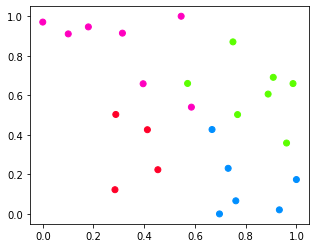

In [124]:
plt.figure(figsize=(5,4))
plt.scatter(df_norm['lon'],df_norm['lat'],c=clustering.labels_,cmap='gist_rainbow')
# df1_norm['lon']

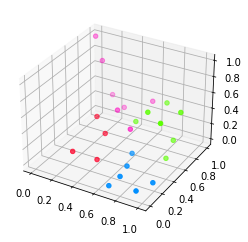

In [125]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs = df_norm['lon'], ys = df_norm['lat'], zs=df_norm['altitud'],\
           c=clustering.labels_,cmap='gist_rainbow')

In [126]:
df_cluster['cluster']=clustering.labels_

In [127]:
df_cluster.to_csv('../datos/3.0.spi_spei/cluster_4.csv', index = False)

In [128]:
df_cluster

,id,lon,lat,altitud,estacion,hmed,pp_bc,spei12,tmax_bc,tmin_bc,cluster
0,100,-67.079722,-17.952778,3702,aeropuerto,60.655186,448.4478,0.186025,18.581675,-0.034583,1
1,101,-67.506389,-18.771944,3762,andamarca,48.862883,348.6445,0.366750,18.186233,0.244008,2
2,102,-66.882900,-18.492900,4057,antequera,55.959790,459.4989,0.211642,14.203808,2.982425,1
3,105,-66.813889,-17.836944,4025,chillca,60.655186,448.0458,0.306492,14.900433,-0.449425,1
4,106,-67.899000,-18.097000,3867,choquecota,52.255141,680.9564,0.105533,17.062517,-2.315667,3
5,107,-67.678611,-18.343889,3758,corque,52.277298,273.4203,0.103925,18.134683,0.338475,2
6,108,-68.706389,-18.177778,3906,cosapa,47.388579,416.2847,0.490233,17.222608,-2.769383,0
7,111,-68.257222,-18.787222,3746,huachacalla,40.800955,455.9969,0.356200,17.720517,-0.961083,0
8,112,-67.939722,-17.835556,3873,huayllamarca,52.255141,476.9313,0.110617,16.733958,1.710108,1
9,113,-66.959722,-19.230000,3724,quillacas,52.778861,305.9486,0.081508,19.478500,-0.217475,2
